# ChnSentiCorp_htl_all 说明
0. **下载地址：** [Github](https://github.com/SophonPlus/ChineseNlpCorpus/raw/master/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv)
1. **数据概览：** 7000 多条酒店评论数据，5000 多条正向评论，2000 多条负向评论
2. **推荐实验：** 情感/观点/评论 倾向性分析
2. **数据来源：**[携程网](http://www.ctrip.com/)
3. **原数据集：** ChnSentiCorp_htl，由 [谭松波](http://people.ucas.ac.cn/~0012244) 老师整理的一份数据集
4. **加工处理：**
    1. 将原来 1 万个离散的文件整合到 1 个文件中
    2. 将负向评论的 label 从 -1 改成 0
    3. 去重

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,Embedding,BatchNormalization,Dropout,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = ''

# 1. ChnSentiCorp_htl_all.csv

## 加载数据

In [3]:
pd_all = pd.read_csv(path + 'ChnSentiCorp_htl_all.csv')

print('评论数目（总体）：%d' % pd_all.shape[0])
print('评论数目（正向）：%d' % pd_all[pd_all.label==1].shape[0])
print('评论数目（负向）：%d' % pd_all[pd_all.label==0].shape[0])

评论数目（总体）：7766
评论数目（正向）：5322
评论数目（负向）：2444


## 字段说明

| 字段 | 说明 |
| ---- | ---- |
| label | 1 表示正向评论，0 表示负向评论 |
| review | 评论内容 |

In [4]:
pd_all.head(5)

,label,review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"


# 2. 构造平衡语料

- 原数据集中还包含了 3 份平衡语料：ChnSentiCorp_htl_ba_2000, ChnSentiCorp_htl_ba_4000, ChnSentiCorp_htl_ba_6000
- 用随机抽样的方法，很容易构造出类似的平衡语料

In [5]:
pd_positive = pd_all[pd_all.label==1]
pd_negative = pd_all[pd_all.label==0]

def get_balance_corpus(corpus_size, corpus_pos, corpus_neg):
    sample_size = corpus_size // 2
    pd_corpus_balance = pd.concat([corpus_pos.sample(sample_size, replace=corpus_pos.shape[0]<sample_size), \
                                   corpus_neg.sample(sample_size, replace=corpus_neg.shape[0]<sample_size)])
    
    print('评论数目（总体）：%d' % pd_corpus_balance.shape[0])
    print('评论数目（正向）：%d' % pd_corpus_balance[pd_corpus_balance.label==1].shape[0])
    print('评论数目（负向）：%d' % pd_corpus_balance[pd_corpus_balance.label==0].shape[0])    
    
    return pd_corpus_balance

In [6]:
ChnSentiCorp_htl_ba_2000 = get_balance_corpus(6000, pd_positive, pd_negative)

ChnSentiCorp_htl_ba_2000.head(5)

评论数目（总体）：6000
评论数目（正向）：3000
评论数目（负向）：3000


,label,review
2083,1,酒店的设施稍显陈旧，但优质贴心的服务弥补了这次不足，前台入住及退房服务很迅捷有效，很赞。ch...
2424,1,酒店的房间不错，非常宽敞，背靠音乐学院，很安静，经常有美女出入。缺点是此楼是商务用房，很多小...
1792,1,很新的也很好的，拥有豪华的设备设施，气派非凡，住着舒服，完全的超５星的！！
1685,1,如果用一句话来点评：服务远远好过硬件。这次入住了行政湖景房和豪华商务房，感受比较多，就多说几...
477,1,"在洛阳的酒店中还是不错的,餐厅也可以,服务也不错."


## 数据预处理

In [7]:
import hanlp
tokenizer = hanlp.load('LARGE_ALBERT_BASE')

In [8]:
X = ChnSentiCorp_htl_ba_2000.review.tolist()
X[:5]

['酒店的设施稍显陈旧，但优质贴心的服务弥补了这次不足，前台入住及退房服务很迅捷有效，很赞。check-in的时候旁边有位客人在抽烟，我被呛了一下，前台马上问我是不是对烟味敏感并立即打电话对我的房间进行无烟处理。酒店送的小苹果很好吃，烟台苹果名不虚传啊。由于所定房间只含单早，叫餐厅把早餐送了上来，量不多但搭配还过得去。车子要经过一个陡坡才能开进酒店后面的停车场，挺悬的，而且停车场对着厨房的大抽油烟机出口，很怕车子熏一晚上油烟的，建议能改进停车场地。',
 '酒店的房间不错，非常宽敞，背靠音乐学院，很安静，经常有美女出入。缺点是此楼是商务用房，很多小公司在里头，还住了不少学生，高峰期间电梯有点繁忙，半天不到，晚上有骚扰电话，网速比较慢。周围吃饭，消费，酒吧等都很方便。',
 '很新的也很好的，拥有豪华的设备设施，气派非凡，住着舒服，完全的超５星的！！',
 '如果用一句话来点评：服务远远好过硬件。这次入住了行政湖景房和豪华商务房，感受比较多，就多说几句。入住当天虽然没有如约拿到双床房（可能入住人太多，说是还没有打扫好），但是前台安排了最高层的湖景房，补偿了一下。很少见的是每间房只提供单早，每次都要签单，稍微有点麻烦。不过早餐45一份，内容也挺丰富，还有小笼蒸的糕点，很喜欢。在酒店中餐厅消费可以打85折，价格很适中，即使人少也能提供包间，还不设最低消费，不错。离西湖确实比较近，慢慢散步十五分钟左右绝对可以达到。在湖景房或者17楼湖景餐厅还可以看到西湖喷泉、白堤，很享受。门童非常积极主动，除了热情招呼，还会主动询问是否需要拦出租车，知道我们要去机场，还告诉我们等车的位置以及可以在酒店大堂购买机场大巴的车票。客房服务很及时，需要什么东西都会尽快送到，打扫卫生迅速到令人吃惊，我们才一顿早餐的工夫，回来屋子已经收拾整齐。前台工作人员让我印象最深刻的是一名叫欣怡的姑娘，耐心、亲切，在我提出要定多一间房，想看看房后，她很快处理完自己手中的事陪我们前往，提供了很多有帮助的信息说到房间，这确实是唯一令我觉得与这间酒店很不太相称的地方。虽然我很欣赏客房设施的全面，免费提供的水果和饮料，卫生间里既有浴缸又有淋浴房的多种选择。但是，不得不说，设施实在是“太”陈旧了，旧的衣柜的门开闭都有吱吱嘎嘎的声响，还要往上提一提才能关严实。旧的马桶里的水阀的链子都是断的用绳子修补好的，结果还是一个劲儿的断

In [9]:
import re

def find_chn(list_of_string):  #提取汉字
    list_s = []
    pattern = re.compile(r'[^\u4e00-\u9fa5]')
    for s in list_of_string:
        s = re.sub(pattern,'',s)
        list_s.append(s)
    return list_s
        
X_chn = find_chn(X)

In [10]:
X_chn[:4]

['酒店的设施稍显陈旧但优质贴心的服务弥补了这次不足前台入住及退房服务很迅捷有效很赞的时候旁边有位客人在抽烟我被呛了一下前台马上问我是不是对烟味敏感并立即打电话对我的房间进行无烟处理酒店送的小苹果很好吃烟台苹果名不虚传啊由于所定房间只含单早叫餐厅把早餐送了上来量不多但搭配还过得去车子要经过一个陡坡才能开进酒店后面的停车场挺悬的而且停车场对着厨房的大抽油烟机出口很怕车子熏一晚上油烟的建议能改进停车场地',
 '酒店的房间不错非常宽敞背靠音乐学院很安静经常有美女出入缺点是此楼是商务用房很多小公司在里头还住了不少学生高峰期间电梯有点繁忙半天不到晚上有骚扰电话网速比较慢周围吃饭消费酒吧等都很方便',
 '很新的也很好的拥有豪华的设备设施气派非凡住着舒服完全的超星的',
 '如果用一句话来点评服务远远好过硬件这次入住了行政湖景房和豪华商务房感受比较多就多说几句入住当天虽然没有如约拿到双床房可能入住人太多说是还没有打扫好但是前台安排了最高层的湖景房补偿了一下很少见的是每间房只提供单早每次都要签单稍微有点麻烦不过早餐一份内容也挺丰富还有小笼蒸的糕点很喜欢在酒店中餐厅消费可以打折价格很适中即使人少也能提供包间还不设最低消费不错离西湖确实比较近慢慢散步十五分钟左右绝对可以达到在湖景房或者楼湖景餐厅还可以看到西湖喷泉白堤很享受门童非常积极主动除了热情招呼还会主动询问是否需要拦出租车知道我们要去机场还告诉我们等车的位置以及可以在酒店大堂购买机场大巴的车票客房服务很及时需要什么东西都会尽快送到打扫卫生迅速到令人吃惊我们才一顿早餐的工夫回来屋子已经收拾整齐前台工作人员让我印象最深刻的是一名叫欣怡的姑娘耐心亲切在我提出要定多一间房想看看房后她很快处理完自己手中的事陪我们前往提供了很多有帮助的信息说到房间这确实是唯一令我觉得与这间酒店很不太相称的地方虽然我很欣赏客房设施的全面免费提供的水果和饮料卫生间里既有浴缸又有淋浴房的多种选择但是不得不说设施实在是太陈旧了旧的衣柜的门开闭都有吱吱嘎嘎的声响还要往上提一提才能关严实旧的马桶里的水阀的链子都是断的用绳子修补好的结果还是一个劲儿的断在我们自己维修过两次后不得已求助客房服务他们立刻通知工程部的维修人员很快换上了新的带铁链的接着即刻又有客房服务人员打扫干净衔接的那么好服务总是无可挑剔中途加定的豪华客房据说是按照五星级标准装修的不过装修的品位着实不怎么样

In [11]:
def trunc_str(list_of_string,length):   # 切割字符串，保留最后100个汉字
    X_cut = []
    for i in list_of_string:
        X_cut.append(i[-1*length:])
    return X_cut

X_cut = trunc_str(X_chn,100)

X_cut[:4]

['烟台苹果名不虚传啊由于所定房间只含单早叫餐厅把早餐送了上来量不多但搭配还过得去车子要经过一个陡坡才能开进酒店后面的停车场挺悬的而且停车场对着厨房的大抽油烟机出口很怕车子熏一晚上油烟的建议能改进停车场地',
 '酒店的房间不错非常宽敞背靠音乐学院很安静经常有美女出入缺点是此楼是商务用房很多小公司在里头还住了不少学生高峰期间电梯有点繁忙半天不到晚上有骚扰电话网速比较慢周围吃饭消费酒吧等都很方便',
 '很新的也很好的拥有豪华的设备设施气派非凡住着舒服完全的超星的',
 '床房而您参观的是商务豪华大床房由于房间格局的不同商务豪华双床房内由带琴凳的单人沙发代替了组合沙发同时我们酒店也在逐步对老楼层的设施设备做进一步的改进您的建议对我们很重要再次表示感谢衷心期待您的再次光临']

In [12]:
X_token = tokenizer(X_cut)  # 分词

In [13]:
# 最长最短评论长度
def get_min_max(list_of_list_of_string):
    len_list=[]
    for i in list_of_list_of_string:
        len_list.append(len(i))
    return max(len_list),min(len_list)
        
min_str,max_str = get_min_max(X_token) # 最长的token有XXX个词
min_str,max_str

(80, 1)

In [14]:
from collections import Counter
import operator

# 词频统计
def count_words(list_of_list_of_string):
    counter = Counter()
    for i in list_of_list_of_string:
        for j in i:
            if j is not ' ':
                counter[j]+=1
                
    sorted_counter = dict(sorted(counter.items(),key=operator.itemgetter(1),reverse=True))
    return sorted_counter


vocab_dict = count_words(X_token)
print(len(vocab_dict))

14381


In [15]:
stopwords = ['的','酒店','房间','了','我','我们']

In [17]:
def get_rarewords(list_of_list_of_string, threshold):
    rarewords = [] 
    for key in list_of_list_of_string:
        if list_of_list_of_string[key]<=threshold:
            rarewords.append(key)
    return rarewords

rarewords = get_rarewords(vocab_dict, 1)

print(len(rarewords))

6288


In [18]:
# 删除停止词
def delete_stopwords(list_of_list_of_string,stopwords):
    for i in list_of_list_of_string:
        for j in i:
            if j in stopwords:
                i.remove(j)
    return list_of_list_of_string

X_token2 = delete_stopwords(X_token,stopwords+rarewords)

vocab_dict2 = count_words(X_token2)
print(len(vocab_dict2))

9184


In [19]:
min_str,max_str = get_min_max(X_token2) # 最长的token有XXX个词
min_str,max_str

(69, 0)

In [20]:
tokenizer2 = Tokenizer(num_words=8000, oov_token="<OOV>")  # oov_token: handle out of vocabulary words
tokenizer2.fit_on_texts(vocab_dict2)

In [21]:
word_index = tokenizer2.word_index
print(word_index)

{'<OOV>': 1, '不': 2, '是': 3, '很': 4, '还': 5, '也': 6, '有': 7, '一': 8, '好': 9, '在': 10, '服务': 11, '个': 12, '都': 13, '就': 14, '住': 15, '不错': 16, '的': 17, '没有': 18, '要': 19, '太': 20, '说': 21, '比较': 22, '会': 23, '和': 24, '去': 25, '差': 26, '可以': 27, '入住': 28, '这': 29, '能': 30, '大': 31, '早餐': 32, '到': 33, '人': 34, '酒店': 35, '感觉': 36, '没': 37, '小': 38, '非常': 39, '设施': 40, '价格': 41, '但': 42, '给': 43, '来': 44, '方便': 45, '您': 46, '天': 47, '前台': 48, '携程': 49, '房间': 50, '环境': 51, '就是': 52, '服务员': 53, '再': 54, '宾馆': 55, '一般': 56, '多': 57, '最': 58, '客人': 59, '只': 60, '而且': 61, '过': 62, '但是': 63, '晚上': 64, '对': 65, '下次': 66, '星': 67, '次': 68, '家': 69, '位置': 70, '才': 71, '什么': 72, '让': 73, '还是': 74, '里': 75, '态度': 76, '不过': 77, '时': 78, '上': 79, '两': 80, '干净': 81, '比': 82, '高': 83, '地方': 84, '算': 85, '年月日': 86, '又': 87, '如果': 88, '有点': 89, '这样': 90, '后': 91, '得': 92, '建议': 93, '着': 94, '点': 95, '他们': 96, '免费': 97, '用': 98, '装修': 99, '离': 100, '较': 101, '卫生间': 102, '了': 103, '知道': 104, '实在': 105, '因为': 

In [22]:
sequences = tokenizer2.texts_to_sequences(X_token2)
print(sequences[0])

[3655, 1920, 3656, 161, 276, 355, 274, 60, 670, 5759, 246, 109, 142, 32, 236, 875, 42, 4458, 5, 1204, 1713, 19, 739, 8, 12, 71, 30, 35, 558, 505, 61, 505, 1368, 850, 31, 1481, 4, 837, 1713, 2544, 8, 64, 4459, 17, 93, 30, 330, 559]


In [23]:
padded = pad_sequences(sequences, padding='post')
print(padded[0])

[3655 1920 3656  161  276  355  274   60  670 5759  246  109  142   32
  236  875   42 4458    5 1204 1713   19  739    8   12   71   30   35
  558  505   61  505 1368  850   31 1481    4  837 1713 2544    8   64
 4459   17   93   30  330  559    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [24]:
print(len(padded[0]))

69


In [27]:
ChnSentiCorp_htl_ba_2000.label.tolist()

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [28]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train, y_val = train_test_split(padded, ChnSentiCorp_htl_ba_2000.label.tolist(), test_size=0.2, random_state=1996)

In [29]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

4800
4800
1200
1200


In [30]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [31]:
y_train.shape

(4800,)

## modeling

In [37]:
from tensorflow.keras.layers import GRU,LSTM,Dense,BatchNormalization,Dropout,Flatten

model = Sequential()
model.add(Embedding(8000,300,input_length=67))
model.add(GRU(12,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
history = model.fit(X_train, y_train, epochs=10, batch_size=8,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
600/600 [==============================] - 19s 32ms/step - loss: 0.5755 - accuracy: 0.6506 - val_loss: 0.3772 - val_accuracy: 0.8350
Epoch 2/10
600/600 [==============================] - 19s 32ms/step - loss: 0.2494 - accuracy: 0.9015 - val_loss: 0.3774 - val_accuracy: 0.8558
Epoch 3/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0980 - accuracy: 0.9683 - val_loss: 0.3662 - val_accuracy: 0.8817
Epoch 4/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0414 - accuracy: 0.9867 - val_loss: 0.4766 - val_accuracy: 0.8783
Epoch 5/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0169 - accuracy: 0.9942 - val_loss: 0.7803 - val_accuracy: 0.8350
Epoch 6/10
600/600 [==============================] - 21s 35ms/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.6306 - val_accuracy: 0.8808
Epoch 7/10
600/600 [==============================] - 21s 36ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.8110 - val_accuracy:

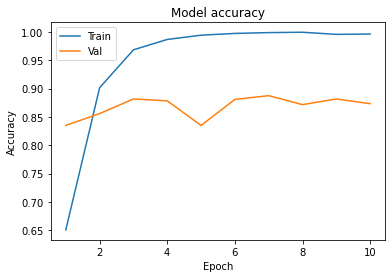

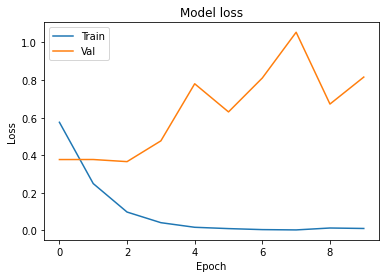

In [39]:
epoch_range=range(1,10+1)
plt.plot(epoch_range,history.history['accuracy'])
plt.plot(epoch_range,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()